We look at Peschel-Emery line for spin half and greater models. The Hamiltonians is 

$$ H = \sum_{j} H_{j,j+1} $$


with 

$$ H^{PE}_{j,j+1}(l) = -\sigma^x_{j}\sigma^x_{j+1} 
+ \frac{h(l)}{2}(\sigma_j^z + \sigma_{j+1}^z) 
+ U(l)\sigma^z_{h}\sigma^z_{j+1}
+ (U(l) + 1)$$

where
$$ U(l) = \frac{1}{2}\left[ \cosh(l)-1\right] $$
and
$$ h(l) = \sinh(l)$$

For open boundary conditions this can be modelled using an MPO like

$$H_i(L) = \left(
\begin{array}{ccc}
I_i & \sigma_i^x & \sigma_i^z & \frac{c(i)}{2}\left(h(l)\sigma^z_i + U(l) + 1\right)\\
0   &     0      &     0      & -\sigma_i^x\\
0   &     0      &     0      & U(l)\sigma_i^z \\
0   &     0      &     0      &  I
\end{array}
\right)$$

Where $c(i) = 2 \forall i s.t. 1 < i < N$ otherwise $c(i) = 1$

MPO construction 

$$ 
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
=
\left( 
  \begin{array}{ccc} 
    I \otimes I & I \otimes \sigma^x & I \otimes I + \sigma^x \otimes \sigma^x + I \otimes I \\
    0 & 0 & \sigma^x \otimes I\\
    0 & 0 & I \otimes I
  \end{array}
\right)
$$

$$ 
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
=
\left( 
  \begin{array}{ccc} 
    I \otimes I \otimes I & I \otimes I \otimes \sigma^x & I \otimes I \otimes I + I \otimes \sigma^x \otimes \sigma^x + I \otimes I \oteims I + 
    + I \otimes \sigma^x \otimes \sigma^x \\
    0 & \sigma^x \otimes \sigma^x \otimes \sigma^x
  \end{array}
\right)
$$

In [27]:
import sympy as sy

N = 3

U = sy.Symbol('U')
h = sy.Symbol('h')
sxs = [sy.Symbol('sx_' + str(x)) for x in range(N)]
szs = [sy.Symbol('sz_' + str(x)) for x in range(N)]
Is = [sy.Symbol('I_' + str(x)) for x in range(N)]

L = sy.Matrix([[1, 0, 0, 0]])
R = sy.Matrix([[0], [0], [0], [1]])

mats = [sy.Matrix([[Is[x], sxs[x], szs[x], szs[x] * h/2 + U + 1], [0, 0, 0, sxs[x]], [0, 0, 0, U*szs[x]], [0, 0, 0, Is[x]]]) for x in range(N)]

A = mats[0]
for i in range(1,len(mats)):
    A = A * mats[i]
    
L*A*R

Matrix([[I_0*I_1*(U + h*sz_2/2 + 1) + I_0*U*sz_1*sz_2 + I_0*sx_1*sx_2 + I_2*(I_0*(U + h*sz_1/2 + 1) + I_1*(U + h*sz_0/2 + 1) + U*sz_0*sz_1 + sx_0*sx_1)]])

In [15]:
import numpy as np
print(L.shape)
print(mats[0].shape)
print(R.shape)
R.dot(mats[0])

(1, 2)
(3, 3)
(2, 1)


ShapeError: Dimensions incorrect for dot product.

## Create new class to implement model

In [5]:
from parafermions.MPO import MPO
import parafermions.ParafermionUtilsCython as pfcy
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: TkAgg


In [2]:
class PeschelEmerySpinHalf(MPO):
    """
    Class which contains method for treating Peschel Emery line of parameters
    """

    def __init__(self, L, l, dtype=np.dtype('complex128')):
        """
        Constructor of spin half Peschel Emergy chain operator class with the given parameters.

        Parameters
        -----------        
        L: int
            Length of chain.
        l: float
            The sinlge parameter of the Peschel Emery spin half line
        dtype: dtype
            Datatype to use internally, default=np.dtype('complex128').
        """
        self.L = L   # otherwise full hamiltonian        
        self.l = l
        self.N = 2
        
        # setting dimension and datatype
        self.dim = self.N**self.L
        self.dtype = dtype
        self.chi = 4
        
        self.sigmax = np.zeros((2, 2), dtype=self.dtype)
        self.sigmax[0, 1] = 1; self.sigmax[1, 0] = 1
        
        self.sigmaz = np.zeros((2, 2), dtype=self.dtype)
        self.sigmaz[0, 0] = 1; self.sigmaz[1, 1] = -1
        
        self.I = np.eye(2, dtype=self.dtype)
        self.Ul = (np.cosh(self.l) - 1)/2.0
        self.hl = np.sinh(l)
        
        c_i = lambda x: 2 if x > 0 and x < self.L-1 else 1 

        Ws = dict() # create a dictionary to store tensors
        for i in range(self.L):
            W = np.zeros((self.chi,self.chi,self.N,self.N), dtype=self.dtype)                        
            W[0,0:4] = [self.I, self.sigmax, self.sigmaz, c_i(i)/2*(self.hl*self.sigmaz + self.I *(self.Ul + 1))]
            W[1,-1] = -self.sigmax
            W[2,-1] = self.Ul * self.sigmaz
            W[-1,-1] = self.I
            Ws[i] = W
        
        self.shape = (self.N**self.L, self.N**self.L) # for mat vec routine
        self.Lp = np.zeros(self.chi, dtype=dtype); self.Lp[0] = 1.0
        self.Rp = np.zeros(self.chi, dtype=dtype); self.Rp[-1] = 1.0
        self.Ws = Ws

In [3]:
class ParitySpinHalf(MPO):
    """
    Parity operator for spin half chains
    """

    def __init__(self, L, dtype=np.dtype('complex128')):
        """
        Parity operator for spin half chains

        Parameters
        -----------        
        L: int
            Length of chain.        
        dtype: dtype
            Datatype to use internally, default=np.dtype('complex128').
        """
        self.L = L   # otherwise full hamiltonian        
        self.N = 2
        
        # setting dimension and datatype
        self.dim = self.N**self.L
        self.dtype = dtype
        self.chi = 1
        
        self.sigmaz = np.zeros((2, 2), dtype=self.dtype)
        self.sigmaz[0, 0] = 1; self.sigmaz[1, 1] = -1
        
        self.I = np.eye(2, dtype=self.dtype)
                
        Ws = dict() # create a dictionary to store tensors
        for i in range(self.L):
            W = np.zeros((self.chi,self.chi,self.N,self.N), dtype=self.dtype)                        
            W[0,0] = self.sigmaz            
            Ws[i] = W
        
        self.shape = (self.N**self.L, self.N**self.L) # for mat vec routine
        self.Lp = np.zeros(self.chi, dtype=dtype); self.Lp[0] = 1.0
        self.Rp = np.zeros(self.chi, dtype=dtype); self.Rp[-1] = 1.0
        self.Ws = Ws

[-3.07240959e-15  8.88227654e-15  5.66916941e-01  5.70340557e-01
  1.00265238e+00  1.01103737e+00  1.60112845e+00  1.63295299e+00
  1.63440385e+00  1.67056747e+00]
Energy expectations: [3.311217547499627e-16, 3.0047503852193155e-16]
Parity expectations: [0.9999954661329883, -0.9999954661329884]


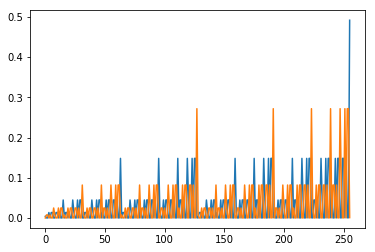

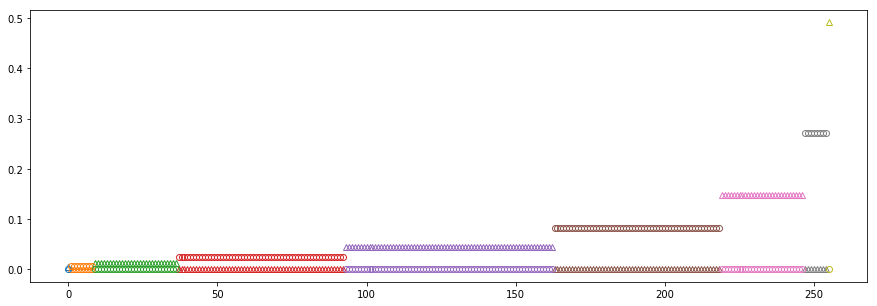

In [7]:
import parafermions as pf
import numpy as np

N = 8
l = 1.2
pe = PeschelEmerySpinHalf(N, l, dtype=np.dtype('float64'))
d, v = pe.Diagonalise(k=100)
print(d[:10])
P = ParitySpinHalf(N, dtype=np.dtype('float64'))

w = pf.diagonalise(v[:,:2], P)
w.shape

print('Energy expectations: ' + str([pe.expectation(w[:, x]) for x in range(w.shape[1])]))
print('Parity expectations: ' + str([P.expectation(w[:, x]) for x in range(w.shape[1])]))

plt.plot(w)

def str_conf(idx, N):
    x = np.base_repr(idx)    
    return '0'*(N-len(x)) + x

def up_count(idx):
    return len([x for x in np.base_repr(idx) if x == '1'])

import seaborn as sns
colors = sns.color_palette(n_colors=N+1)


plt.figure(figsize=(15,5))
i = 0
sorted_tuples = sorted([[up_count(x), w[x, i]] for x in range(w.shape[0])], key=lambda x: x[0])
for j, t in enumerate(sorted_tuples):
    plt.plot(j, t[1], '^', color=colors[t[0]], fillstyle='none')
    
i = 1
sorted_tuples = sorted([[up_count(x), w[x, i]] for x in range(w.shape[0])], key=lambda x: x[0])
for j, t in enumerate(sorted_tuples):
    plt.plot(j, t[1], 'o', color=colors[t[0]], fillstyle='none')

In [185]:
np.exp(-0.05)

0.951229424500714

In [121]:
import seaborn as sns
sns.color_palette

<function seaborn.palettes.color_palette(palette=None, n_colors=None, desat=None)>

In [122]:
foo = '110'

len([x for x in foo if x == '1'])

2

In [95]:
i = 1
[[str_conf(x, N), w[x, i]] for x in range(w.shape[0])]

[['00000', 0.2199361714928983],
 ['00001', 1.2490009027033009e-16],
 ['00010', 1.9428902930940235e-16],
 ['00011', 0.24306706056684935],
 ['00100', 2.6367796834847463e-16],
 ['00101', 0.24306706056684937],
 ['00110', 0.24306706056684912],
 ['00111', -5.5511151231257815e-17],
 ['01000', -4.1633363423443364e-17],
 ['01001', 0.2430670605668493],
 ['01010', 0.24306706056684924],
 ['01011', 1.52655665885959e-16],
 ['01100', 0.24306706056684926],
 ['01101', -2.4980018054066017e-16],
 ['01110', 9.714451465470117e-17],
 ['01111', 0.2686306464806142],
 ['10000', -1.52655665885959e-16],
 ['10001', 0.2430670605668493],
 ['10010', 0.2430670605668491],
 ['10011', -1.3877787807814454e-16],
 ['10100', 0.24306706056684918],
 ['10101', -9.714451465470117e-17],
 ['10110', 5.5511151231257815e-17],
 ['10111', 0.2686306464806137],
 ['11000', 0.2430670605668493],
 ['11001', 0.0],
 ['11010', 2.9143354396410354e-16],
 ['11011', 0.2686306464806139],
 ['11100', 1.3877787807814454e-16],
 ['11101', 0.268630646480

# Attempt the three state potts typed model

In [289]:
class PeschelEmery3StateClock(MPO):
    """
    Class which contains method for treating Peschel Emery line of parameters
    """

    def __init__(self, L, r, dtype=np.dtype('complex128')):
        """
        Constructor of spin half Peschel Emergy chain operator class with the given parameters.

        Parameters
        -----------        
        L: int
            Length of chain.
        r: float
            The sinlge parameter of the Peschel Emery spin half line
        dtype: dtype
            Datatype to use internally, default=np.dtype('complex128').
        """
        self.L = L   # otherwise full hamiltonian        
        self.r = r
        self.N = 3
        
        # setting dimension and datatype
        self.dim = self.N**self.L
        self.dtype = dtype
        self.chi = 8
        self.omega = np.exp(2j*np.pi/3)
        
        self.sigmax = np.zeros((3, 3), dtype=self.dtype)
        self.sigmax[0, 1] = 1; self.sigmax[1, 2] = 1; self.sigmax[2, 0] = 1
        
        self.sigmaz = np.diag([self.omega**x for x in range(3)])
        
        self.I = np.eye(3, dtype=self.dtype)
        self.fr = (1+2*r)*(1-r**3)/(9*r**2)
        self.g1r = -2*(1-r)**2*(1+r+r**2)/(9*r**2)
        self.g2r = (1-r)**2*(1-2*r-2*r**2)/(9*r**2)
        self.er = 2*(1+r+r**2)**2/(9*r**2)
        
        c = lambda x: 2 if x > 0 and x < self.L-1 else 1 

        Ws = dict() # create a dictionary to store tensors
        for i in range(self.L):
    
            W = np.zeros((self.chi,self.chi,self.N,self.N), dtype=self.dtype)                        
            W[0,0:3] = [self.I, self.sigmax.conj().T, self.sigmax]
            W[0,3:5] = [self.sigmaz, self.sigmaz.conj().T]
            W[0,5:7] = [self.sigmaz, self.sigmaz.conj().T]
            W[0,7] = c(i)*(-self.fr*(self.sigmaz + self.sigmaz.conj().T) + self.er*self.I/2)
            W[1,-1] = -self.sigmax; W[2,-1] = -self.sigmax.conj().T
            W[3, -1] = -self.g1r*self.sigmaz
            W[4, -1] = -self.g1r*self.sigmaz.conj().T
            W[5, -1] = -self.g2r*self.sigmaz.conj().T
            W[6, -1] = -self.g2r*self.sigmaz            
            W[-1,-1] = self.I
            Ws[i] = W
        
        self.shape = (self.N**self.L, self.N**self.L) # for mat vec routine
        self.Lp = np.zeros(self.chi, dtype=dtype); self.Lp[0] = 1.0
        self.Rp = np.zeros(self.chi, dtype=dtype); self.Rp[-1] = 1.0
        self.Ws = Ws

In [322]:
pe3 = PeschelEmery3StateClock(8, 1)
p, v = pe3.Diagonalise(k=20)
[np.abs(x) for x in p]

[7.281880779580773e-16,
 1.83009671239813e-15,
 3.1153857165994994e-15,
 3.0000000000000013,
 3.0000000000000093,
 3.000000000000011,
 3.0000000000000115,
 3.000000000000019,
 3.00000000000002,
 3.000000000000024,
 3.0000000000000298,
 3.000000000000035,
 3.000000000000039,
 3.000000000000046,
 3.0000000000000484,
 3.0000000000000533,
 3.0000000000000915,
 6.0000000000000275,
 6.000000000000067,
 6.000000000000072]

In [323]:
P = pf.QOp(3, 8)
w = pf.diagonalise(v[:, :3], P)

In [324]:
[P.expectation(w[:, i].conj()) for i in range(w.shape[1])]

[(-0.4999999999999961+0.8660254037844257j),
 (0.9999999999999041+0j),
 (-0.5000000000000282-0.8660254037844881j)]

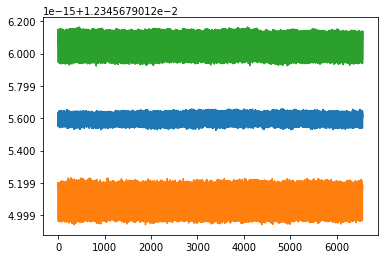

In [325]:
plt.plot(np.abs(w))

In [328]:
np.dot(w[:,0].conj(), w[:,0])

(1.0000000000000044+0j)